In [1]:
import loadArticles
import loadStockInfo
import textProcessing

import en_core_web_lg

import requests
import urllib.parse
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import string

from spacy.gold import GoldParse
from spacy.pipeline import EntityRecognizer
from spacy.tokens import Doc
from spacy.pipeline import EntityRuler

In [2]:
#import sklearn packages
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
#load stock info using meta and historical data
stockInfo = loadStockInfo.loadStockInfo('../../data/stock-market-dataset/stocks/', '../../data/stock-market-dataset/symbols_valid_meta.csv', DEBUG=True)
#stock_df = stockInfo.loadStockDf()
stock_meta_df = pd.read_csv('../../data/stock-market-dataset/symbols_valid_meta.csv', index_col=0)
#stock_meta_df = stock_meta_df[['Symbol', 'Security Name']]
# stock_meta_df['Tag'] = 'ORG'

In [4]:
symbol_df = stock_meta_df[stock_meta_df['ETF'] == 'N']['NASDAQ Symbol']
# symbol_df = symbol_df[symbol_df != 'FB']

In [5]:
# news_by_ticker_dict = {'ticker': [], 'title': [], 'sentiment': [], 'date': []}

In [6]:
symbol_df.reset_index(inplace=True, drop=True)

In [9]:
# symbol_df[symbol_df == 'UTX#']
# symbol_df.iloc[54] = 'CARR'
symbol_df

0          A
1         AA
2       AACG
3        AAL
4       AAMC
        ... 
5879     ZUO
5880     ZVO
5881    ZYME
5882    ZYNE
5883    ZYXI
Name: NASDAQ Symbol, Length: 5884, dtype: object

In [10]:
html_doc = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').content

In [11]:
tables = pd.read_html(html_doc)

In [12]:
SP_500 = tables[0]

In [13]:
#list of symbols to build news from focus on S&P 500 Index Stocks
SP_500['Symbol'].head()


0     MMM
1     ABT
2    ABBV
3    ABMD
4     ACN
Name: Symbol, dtype: object

In [14]:
# req = requests.get(url="https://stocknewsapi.com/api/v1?tickers=MMM&items=50&token=udkw09gzwcqp3zffbhsrcgiqegnytwyda7hlxazy&page=12")
# response = req.json()
# print(response['error'] is None)

In [15]:

# #max 50 per request
# token_api = "udkw09gzwcqp3zffbhsrcgiqegnytwyda7hlxazy"
# #f"https://stocknewsapi.com/api/v1?tickers={ticker}&items=10000&token={token_api}"
# not_counted = ['BRK-B', 'BF-B']
# for ticker in not_counted:
#     #number of pages
#     number_of_pages = 1
#     num = number_of_pages
#     while num <= number_of_pages:
#         # for ticker in symbol_df:
#         stock_news_url = str("https://stocknewsapi.com/api/v1?tickers={}&items=50&token={}&page={}").format(ticker, token_api, num)

#         req = requests.get(url=stock_news_url)
#         response = req.json()
        
#         if 'error' in response:
#             break
#         else:
#             number_of_pages = int(response['total_pages'])
            
#         if response['data'] is None:
#             continue
#         else:
#             for i in response['data']:
#                 news_by_ticker_dict['ticker'].append(ticker)
#                 news_by_ticker_dict['title'].append(i['title'])
#                 news_by_ticker_dict['sentiment'].append(i['sentiment'])
#                 news_by_ticker_dict['date'].append(i['date'])
#         print(f"{ticker} - {num}/{number_of_pages}", end='\n')
#         num+=1

In [16]:
# news_sp_500 = pd.DataFrame(news_by_ticker_dict)
# news_sp_500

In [17]:
# news_sp_500['ticker'] = np.where(news_sp_500['ticker'] == 'BRK-B', 'BRK.B', news_sp_500['ticker'])
# news_sp_500['ticker'] = np.where(news_sp_500['ticker'] == 'BF-B', 'BF.B', news_sp_500['ticker'])

In [18]:
# news_sp_500.sort_values(by='ticker', inplace=True)

In [19]:
# news_sp_500.to_csv('/Users/jjackson/Brainstation/Capstone Project/news_sp_500.csv', index=False)

### Preprocessing Stock Info

#### Adding Feature Price Change of Day (Positive/Negative/Neutral)

In [16]:
stock_df = stockInfo.loadStockDf()

In [18]:
stock_df.shape

(24197442, 9)

In [23]:
stock_df = stock_df.query('Date > "2018-01-30"')

In [24]:
stock_df.shape

(2986292, 9)

In [29]:
stock_df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'symbol','name']

In [30]:
stock_df

,date,open,high,low,close,adj_close,volume,symbol,name
4578,2018-01-31,73.769997,74.389999,73.239998,73.430000,71.956703,2032800.0,A,"Agilent Technologies, Inc. Common Stock"
4579,2018-02-01,73.180000,73.779999,72.510002,72.830002,71.368736,2008200.0,A,"Agilent Technologies, Inc. Common Stock"
4580,2018-02-02,72.320000,72.760002,71.220001,71.250000,69.820442,1955700.0,A,"Agilent Technologies, Inc. Common Stock"
4581,2018-02-05,70.860001,71.480003,68.180000,68.220001,66.851227,2860700.0,A,"Agilent Technologies, Inc. Common Stock"
4582,2018-02-06,66.959999,68.830002,66.129997,68.449997,67.076614,4121200.0,A,"Agilent Technologies, Inc. Common Stock"
...,...,...,...,...,...,...,...,...,...
24197437,2020-03-26,10.230000,11.430000,10.230000,11.100000,11.100000,189500.0,ZYXI,"Zynex, Inc. - Common Stock"
24197438,2020-03-27,10.700000,10.980000,10.060000,10.300000,10.300000,145000.0,ZYXI,"Zynex, Inc. - Common Stock"
24197439,2020-03-30,10.160000,11.060000,10.160000,10.800000,10.800000,162300.0,ZYXI,"Zynex, Inc. - Common Stock"
24197440,2020-03-31,10.680000,11.140000,10.590000,11.070000,11.070000,280400.0,ZYXI,"Zynex, Inc. - Common Stock"


In [21]:
news_by_ticker_df = pd.read_csv("../../data/news/final_news_sent.csv")

In [22]:
news_by_ticker_df

,ticker,title,sentiment,date
0,FB,"By Refusing to Act, Is Zuckerberg Hurting Face...",Neutral,"Sat, 06 Jun 2020 12:23:00 -0400"
1,FB,Zuckerberg: Facebook will review policies afte...,Neutral,"Sat, 06 Jun 2020 00:24:13 -0400"
2,FB,"Facebook, Instagram Take Down Trump George Flo...",Neutral,"Fri, 05 Jun 2020 23:50:21 -0400"
3,FB,"After Employee Backlash Over Trump Posts, Zuck...",Neutral,"Fri, 05 Jun 2020 22:36:29 -0400"
4,FB,Facebook's Zuckerberg promises a review of con...,Neutral,"Fri, 05 Jun 2020 20:23:01 -0400"
...,...,...,...,...
291208,ZTS,Will Boeing go lower? #AskHalftime,Neutral,"Wed, 12 Feb 2020 13:48:26 -0500"
291209,ZTS,Zoetis (ZTS) to Report Q4 Earnings: What's in ...,Neutral,"Mon, 10 Feb 2020 09:25:00 -0500"
291210,ZTS,Zoetis (ZTS) Earnings Expected to Grow: Should...,Positive,"Thu, 06 Feb 2020 12:31:08 -0500"
291211,ZTS,Zoetis Inc. (ZTS) CEO Kristin Peck on Q4 2019 ...,Neutral,"Thu, 13 Feb 2020 15:30:46 -0500"


In [23]:
news_by_ticker_df['sentiment'].value_counts()

Positive    133725
Neutral     108401
Negative     49087
Name: sentiment, dtype: int64

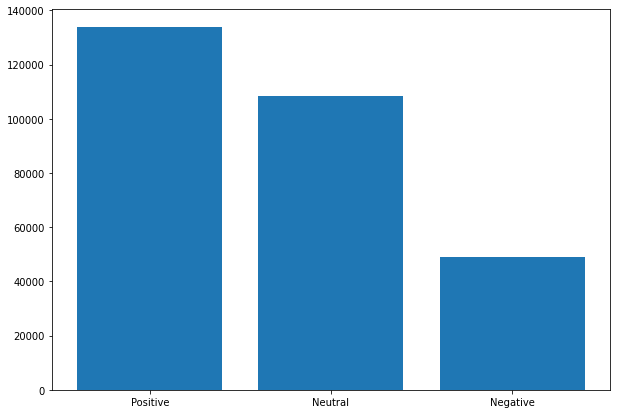

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.bar(news_by_ticker_df['sentiment'].value_counts().index, news_by_ticker_df['sentiment'].value_counts().values)
plt.show()

In [25]:
news_by_ticker_df.shape

(291213, 4)

In [14]:
#get entities from article headline
nlp = en_core_web_lg.load()
ruler = EntityRuler(nlp)

#creating pattersn for entity ruler
temp_df1 = stock_meta_df[['Tag', 'Symbol']]
temp_df1.columns = ['label', 'pattern']
temp_df2 = stock_meta_df[['Tag', 'Name']]
temp_df2.columns = ['label', 'pattern']

temp_df = pd.concat([temp_df1, temp_df2])

#set patterns
patterns = temp_df.to_dict('records')
#add patterns to ruler
ruler.add_patterns(patterns)
#add ruler to nlp
nlp.add_pipe(ruler)

tp = textProcessing.textProcessing(nlp)

In [26]:
#format date to connect stock info later
news_by_ticker_df['date'] = pd.to_datetime(pd.to_datetime(news_by_ticker_df['date'], utc=True).dt.strftime("%m/%d/%y"))

#now that we have news_df which has the stock symbol we can derive sentiment and compare with historical price changes
#create mutliple sets of transformed text, train test split data X is Headline y is sentiment
#convert sentiment
# 0 -> Positive
# 1 -> Negative
# 2 -> Neutral
news_by_ticker_df['sentiment'] = np.where(news_by_ticker_df['sentiment'] == 'Positive', 0, news_by_ticker_df['sentiment'])
news_by_ticker_df['sentiment'] = np.where(news_by_ticker_df['sentiment'] == 'Negative', 1, news_by_ticker_df['sentiment'])
news_by_ticker_df['sentiment'] = np.where(news_by_ticker_df['sentiment'] == 'Neutral', 2, news_by_ticker_df['sentiment'])

In [27]:
news_by_ticker_df = news_by_ticker_df.astype({'sentiment': 'int32'})
print(news_by_ticker_df.dtypes)

ticker               object
title                object
sentiment             int32
date         datetime64[ns]
dtype: object


In [ ]:
#set up GridSearchCV for best params of DT and Logistic Regression
lr_parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
dt_parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [28]:
#set X and y
X = news_by_ticker_df['title']
y = news_by_ticker_df['sentiment']

In [16]:
#since the size of the df is (134611, 4) I feel we can have a validation set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=1)

In [17]:
X_train.shape

(75381,)

In [18]:
X_validation.shape

(32307,)

In [19]:
#text processing
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
import nltk
from nltk.corpus import stopwords

In [21]:
 def tokenizeNLTK(sentence):
    try:
        stemmer = nltk.stem.PorterStemmer()
        ENGLISH_STOP_WORDS = stopwords.words('english')

        for punctuation_mark in string.punctuation:
            # Remove punctuation and set to lower case
            sentence = sentence.replace(punctuation_mark,'').lower()

        # split sentence into words
        listofwords = sentence.split(' ')
        listofstemmed_words = []


        # Remove stopwords and any tokens that are just empty strings
        for word in listofwords:
            if (not word in ENGLISH_STOP_WORDS) and (word!=''):
                # Stem words
                stemmed_word = stemmer.stem(word)
                listofstemmed_words.append(stemmed_word)

        return listofstemmed_words

    except Exception as e:
        print(f"Something went wrong in tokenizeNLTK: {e}")

In [22]:
def tokenizeSpacy(sentence):
    try:
        for punctuation_mark in string.punctuation:
            # Remove punctuation and set to lower case
            sentence = sentence.replace(punctuation_mark,'').lower()

        doc = nlp(sentence)

        listofwords = list()
        for token in doc:
            if not token.is_stop:
                if token.is_alpha:
                    listofwords.append(token.lemma_.strip().lower())

        return listofwords
    except Exception as e:
        print(f"Something went wrong in tokenizeSpacy: {e}")

## CountVectorizer Testing

In [23]:
print_line = "\n=======================================================\n"

### Spacy Usage

In [ ]:
#CountVectorizer on X_train, X_validation using Spacy
countVectorizerSpacy = CountVectorizer(tokenizer=tokenizeSpacy, min_df=10, ngram_range=(1,3))

In [ ]:
countVectorizerSpacy.fit(X_train)

In [ ]:
#transform with Spacy CountVectorizer
X_train_countSpacy = countVectorizerSpacy.transform(X_train)

In [ ]:
X_train_countSpacy.shape

In [ ]:
X_validation_countSpacy = countVectorizerSpacy.transform(X_validation)

In [ ]:
#convert back to dataframes
X_train_countSpacy = pd.DataFrame(X_train_countSpacy.toarray(), columns=countVectorizerSpacy.get_feature_names())
X_validation_countSpacy = pd.DataFrame(X_validation_countSpacy.toarray(), columns=countVectorizerSpacy.get_feature_names())

In [ ]:
print(f"X_train shape: {X_train_countSpacy.shape} - X_validation shape: {X_validation_countSpacy.shape}")

In [ ]:
#try different models see accuracy
#for CountVectorize we try LogisticRegression & Decision Trees
#train and run on validation set to hypertune Spacy
logit_spacy = LogisticRegression(max_iter=1000)
logit_spacy.fit(X_train_countSpacy, y_train)

In [ ]:
#get predicted
y_pred_spacy = logit_spacy.predict(X_validation_countSpacy)
report_spacy = classification_report(y_validation, y_pred_spacy)

In [ ]:
print("Validation Spacy Confusion Matrix:", print_line, confusion_matrix(y_validation, y_pred_spacy))
print("\nValidation Spacy Data Classification Report:", print_line, report_spacy)

In [ ]:
C_range = [.000001, .00001, .0001, .001, .01,.1, 1, 10, 100]
train_scores = list()
validation_scores = list()
for index, c in enumerate(C_range):
    print(index, end='\r')
    logit_test = LogisticRegression(C=c, max_iter=1000)
    logit_test.fit(X_train_countSpacy, y_train)
    validation_scores.append(logit_test.score(X_validation_countSpacy, y_validation))
    train_scores.append(logit_test.score(X_train_countSpacy, y_train))

In [ ]:
#Plot validation and train scores
plt.figure(figsize=(12,7))
plt.plot(range(6), validation_scores, label="Validation")
plt.plot(range(6), train_scores, label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Position for C_range")
plt.show()

In [ ]:
best_c = C_range[validation_scores.index(np.max(validation_scores))]
best_c

In [ ]:
#count vectorizer
countVectorizerSpacy.fit(X_remainder)
X_remainder_countSpacy = countVectorizerSpacy.transform(X_remainder)
X_test_countSpacy = countVectorizerSpacy.transform(X_test)

In [ ]:
X_remainder_countSpacy = pd.DataFrame(X_remainder_countSpacy.toarray(), columns=countVectorizerSpacy.get_feature_names())
X_test_countSpacy = pd.DataFrame(X_test_countSpacy.toarray(), columns=countVectorizerSpacy.get_feature_names())

In [ ]:
X_remainder_countSpacy.shape

In [ ]:
X_test_countSpacy.shape

In [ ]:
#run on test set
logit_spacy = LogisticRegression(C=best_c, max_iter=1000)

In [ ]:
logit_spacy.fit(X_remainder_countSpacy, y_remainder)

In [ ]:
#get predicted
y_pred_test_spacy = logit_spacy.predict(X_test_countSpacy)
report_test_spacy = classification_report(y_test, y_pred_test_spacy)

In [ ]:
print("Test Spacy Confusion Matrix:", print_line, confusion_matrix(y_test, y_pred_test_spacy))
print("\Test Spacy Data Classification Report:", print_line, report_test_spacy)

### NLTK Usage

In [24]:
#CountVectorizer on X_train, X_validation using NLTK
countVectorizerNLTK = CountVectorizer(tokenizer=tokenizeNLTK, min_df=10, ngram_range=(1,3))
countVectorizerNLTK.fit(X_train)

/Users/jjackson/opt/anaconda3/envs/BrainStationCapstone/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(min_df=10, ngram_range=(1, 3),
                tokenizer=<function tokenizeNLTK at 0x7fcf62f1ae18>)

In [25]:
#transform with NLTK CountVectorizer
X_train_countNLTK = countVectorizerNLTK.transform(X_train)
X_validation_countNLTK = countVectorizerNLTK.transform(X_validation)

In [35]:
#convert back to dataframes
X_train_countNLTK = pd.DataFrame(X_train_countNLTK.toarray(), columns=countVectorizerNLTK.get_feature_names())
X_validation_countNLTK = pd.DataFrame(X_validation_countNLTK.toarray(), columns=countVectorizerNLTK.get_feature_names())

AttributeError: 'DataFrame' object has no attribute 'toarray'

In [47]:
print(f"X_train shape: {X_train_countNLTK.shape} - X_validation shape: {X_validation_countNLTK.shape}")

X_train shape: (75381, 14866) - X_validation shape: (32307, 14866)


In [37]:
#train and run on validation set to hypertune NLTK
logit_NLTK = LogisticRegression(max_iter=1000)
logit_NLTK.fit(X_train_countNLTK, y_train)

LogisticRegression(max_iter=1000)

In [38]:
y_pred_NLTK = logit_NLTK.predict(X_validation_countNLTK)
report_NLTK = classification_report(y_validation, y_pred_NLTK)

In [39]:
print("NLTK Validation Confusion Matrix:", print_line, confusion_matrix(y_validation, y_pred_NLTK))
print("\nNLTK Validation Data Classification Report:", print_line, report_NLTK)

NLTK Validation Confusion Matrix: 
 [[12762   218  1307]
 [  369  3915   484]
 [ 1445   382 11425]]

NLTK Validation Data Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     14287
           1       0.87      0.82      0.84      4768
           2       0.86      0.86      0.86     13252

    accuracy                           0.87     32307
   macro avg       0.87      0.86      0.86     32307
weighted avg       0.87      0.87      0.87     32307



In [41]:
#count vectorizer
countVectorizerNLTK.fit(X_remainder)
X_remainder_countNLTK = countVectorizerNLTK.transform(X_remainder)
X_test_countNLTK = countVectorizerNLTK.transform(X_test)

In [42]:
X_remainder_countNLTK = pd.DataFrame(X_remainder_countNLTK.toarray(), columns=countVectorizerNLTK.get_feature_names())
X_test_countNLTK = pd.DataFrame(X_test_countNLTK.toarray(), columns=countVectorizerNLTK.get_feature_names())

In [43]:
#run on test set
logit_NLTK = LogisticRegression(C=0.01, max_iter=1000)

In [44]:
logit_NLTK.fit(X_remainder_countNLTK, y_remainder)

LogisticRegression(C=0.01, max_iter=1000)

In [45]:
#get predicted
y_pred_test_nltk = logit_NLTK.predict(X_test_countNLTK)
report_test_nltk = classification_report(y_test, y_pred_test_nltk)

In [46]:
print("Test Spacy Confusion Matrix:", print_line, confusion_matrix(y_test, y_pred_test_nltk))
print("\nTest Spacy Data Classification Report:", print_line, report_test_nltk)

Test Spacy Confusion Matrix: 
 [[10494    98  1245]
 [  641  2643   746]
 [ 1378   146  9532]]

Test Spacy Data Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86     11837
           1       0.92      0.66      0.76      4030
           2       0.83      0.86      0.84     11056

    accuracy                           0.84     26923
   macro avg       0.86      0.80      0.82     26923
weighted avg       0.85      0.84      0.84     26923



## TF-IDF Testing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#TF-IDF Spacy
tfidf_Spacy = TfidfVectorizer(min_df=10, tokenizer=tokenizeSpacy, ngram_range = (1,3))
tfidf_Spacy.fit(X_train)

In [ ]:
#transform with NLTK CountVectorizer
X_train_tfidfSpacy = tfidf_Spacy.transform(X_train)
X_validation_tfidfSpacy = tfidf_Spacy.transform(X_validation)

In [ ]:
#convert back to dataframes
X_train_tfidfSpacy = pd.DataFrame(X_train_tfidfSpacy.toarray(), columns=tfidf_Spacy.get_feature_names())
X_validation_tfidfSpacy = pd.DataFrame(X_validation_tfidfSpacy.toarray(), columns=tfidf_Spacy.get_feature_names())

In [ ]:
#TF-IDF NLTK
tfidf_NLTK = TfidfVectorizer(min_df=10, tokenizer=tokenizeNLTK, ngram_range = (1,3))
tfidf_NLTK.fit(X_train)

In [ ]:
#transform with NLTK CountVectorizer
X_train_tfidfNLTK = tfidf_NLTK.transform(X_train)
X_validation_tfidfNLTK = tfidf_NLTK.transform(X_validation)

In [ ]:
#convert back to dataframes
X_train_tfidfNLTK = pd.DataFrame(X_train_tfidfNLTK.toarray(), columns=tfidf_NLTK.get_feature_names())
X_validation_tfidfNLTK = pd.DataFrame(X_validation_tfidfNLTK.toarray(), columns=tfidf_NLTK.get_feature_names())

## Decision Tree Model for TF-IDF & CountVectorizer